# Training

## Importing Libraries and preparing dataset

In [0]:
import os
import cv2
import math
import torch
import shutil
import random
import zipfile
import numpy as np
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from time import time, strftime, gmtime
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage

In [0]:
def create_paths(data_path, model_path):
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    if not os.path.exists(model_path):
        os.makedirs(model_path)

def copy_data(data_path_drive, data_path, data_dir):
    if os.path.exists(os.path.join(data_path, data_dir)):
        print('Data already present. Not copying!')
    else:
        print('Copying data from drive....')
        start = time()
        src = os.path.join(data_path_drive, data_dir+'.zip')
        dst = os.path.join(data_path, data_dir+'.zip')
        shutil.copyfile(src, dst)
        end = time()
        print('Copied | Time Elapsed --> {} seconds'.format(end - start))

def copy_model(model_path_drive, model_path, model_name):
    if os.path.exists(os.path.join(model_path, model_name)):
        print('Model already present. Not copying!')
    else:
        print('Copying model from drive....')
        start = time()
        src = os.path.join(model_path_drive, model_name)
        dst = os.path.join(model_path, model_name)
        shutil.copyfile(src, dst)
        end = time()
        print('Copied | Time Elapsed --> {} seconds'.format(end - start))

def extract(source):
    if not os.path.exists(source):
        print('Dataset not found')
    else:
        print('Extracting....')
        zip_file = source
        zip_ref = zipfile.ZipFile(zip_file, 'r')
        start = time()
        zip_ref.extractall(path="data")
        zip_ref.close()
        os.remove(zip_file)
        end = time()
        print('Extracted | Time Elapsed --> {} seconds'.format(end - start))

data_path = 'data'
model_path = 'model'

data_path_drive = 'drive/My Drive/celeb_detection/data'
model_path_drive = 'drive/My Drive/celeb_detection/model'

data_dir = 'img_align_celeba'
model_name = 'srresnet_14.pt'

create_paths(data_path, model_path)
copy_data(data_path_drive, data_path, data_dir)
copy_model(model_path_drive, model_path, model_name)
extract(os.path.join(data_path, data_dir+'.zip'))

In [0]:
# keep only 120k images for lesser training time

src = 'data/img_align_celeba'
print('Size of dataset before removal = {}'.format(len(list(os.listdir(src)))))
start = time()
for i, files in enumerate(os.listdir(src)):
    if i >= 120000:
        os.remove(os.path.join(src, files))
end = time()
print('Size of dataset after removal = {}'.format(len(list(os.listdir(src)))))
print('Dataset shortened | Time Elapsed = {} seconds'.format(end - start))

Size of dataset before removal = 202599
Size of dataset after removal = 120000
Dataset shortened | Time Elapsed = 2.5331380367279053 seconds


## Creating Data Loader

In [0]:
# making a data loader same as that of mnist in torchvision.datasets

device = 'cuda'
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)


class LoadDataResNet(Dataset):
    def __init__(self, root, crop_size, scaling_factor):
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.files = []
        for i, img in enumerate(os.listdir(root)):
            self.files.append(os.path.join(root, img))

    def __getitem__(self, item):
        img = Image.open(self.files[item], mode='r')
        img = img.convert('RGB')

        left = random.randint(1, img.width - self.crop_size)
        top = random.randint(1, img.height - self.crop_size)
        right = left + self.crop_size
        bottom = top + self.crop_size
        hr_img = img.crop((left, top, right, bottom))

        # Downsize this crop to obtain a low-resolution version of it
        lr_width = int(hr_img.width / self.scaling_factor)
        lr_height = int(hr_img.height / self.scaling_factor)
        lr_img = hr_img.resize((lr_width, lr_height), Image.BICUBIC)

        # Normalize the images after converting into tensors
        transform = ToTensor()
        lr_img = transform(lr_img)
        if lr_img.ndimension() == 3:
            lr_img = (lr_img - imagenet_mean) / imagenet_std
        elif lr_img.ndimension() == 4:
            lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda

        hr_img = transform(hr_img)
        hr_img = 2. * hr_img - 1.

        return lr_img, hr_img

    def __len__(self):
        return len(self.files)


def load_data_resnet(root='', crop_size=96, scaling_factor=4, batch_size=16):
    data = LoadDataResNet(root, crop_size=crop_size, scaling_factor=scaling_factor)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader

class LoadDataGan(Dataset):
    def __init__(self, root, crop_size, scaling_factor):
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.files = []
        for img in os.listdir(root):
            self.files.append(os.path.join(root, img))

    def __getitem__(self, item):
        img = Image.open(self.files[item], mode='r')
        img = img.convert('RGB')

        left = random.randint(1, img.width - self.crop_size)
        top = random.randint(1, img.height - self.crop_size)
        right = left + self.crop_size
        bottom = top + self.crop_size
        hr_img = img.crop((left, top, right, bottom))

        # Downsize this crop to obtain a low-resolution version of it
        lr_width = int(hr_img.width / self.scaling_factor)
        lr_height = int(hr_img.height / self.scaling_factor)
        lr_img = hr_img.resize((lr_width, lr_height), Image.BICUBIC)

        # Normalize the images after converting into tensors
        transform = ToTensor()
        lr_img = transform(lr_img)
        if lr_img.ndimension() == 3:
            lr_img = (lr_img - imagenet_mean) / imagenet_std
        elif lr_img.ndimension() == 4:
            lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda

        hr_img = transform(hr_img)
        if hr_img.ndimension() == 3:
            hr_img = (hr_img - imagenet_mean) / imagenet_std
        elif hr_img.ndimension() == 4:
            hr_img = (hr_img - imagenet_mean_cuda) / imagenet_std_cuda

        return lr_img, hr_img

    def __len__(self):
        return len(self.files)


def load_data_gan(root='', crop_size=96, scaling_factor=4, batch_size=16):
    data = LoadDataGan(root, crop_size=crop_size, scaling_factor=scaling_factor)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader

## SRResNet Architecture

In [0]:
# ResNet Architecture

class SRResNet(nn.Module):
    def __init__(self):
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8 and half of desired upscaling
        scaling_factor = 2

        # The first convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=9 // 2)
        self.activation1 = nn.PReLU()

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm2 = nn.BatchNorm2d(num_features=64)
        self.activation2 = nn.PReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm3 = nn.BatchNorm2d(num_features=64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm4 = nn.BatchNorm2d(num_features=64)
        self.activation4 = nn.PReLU()

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm5 = nn.BatchNorm2d(num_features=64)

        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm6 = nn.BatchNorm2d(num_features=64)
        self.activation6 = nn.PReLU()

        self.conv7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm7 = nn.BatchNorm2d(num_features=64)

        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm8 = nn.BatchNorm2d(num_features=64)
        self.activation8 = nn.PReLU()

        self.conv9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm9 = nn.BatchNorm2d(num_features=64)

        self.conv10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm10 = nn.BatchNorm2d(num_features=64)
        self.activation10 = nn.PReLU()

        self.conv11 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm11 = nn.BatchNorm2d(num_features=64)

        self.conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm12 = nn.BatchNorm2d(num_features=64)
        self.activation12 = nn.PReLU()

        self.conv13 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm13 = nn.BatchNorm2d(num_features=64)

        self.conv14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm14 = nn.BatchNorm2d(num_features=64)
        self.activation14 = nn.PReLU()

        self.conv15 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm15 = nn.BatchNorm2d(num_features=64)

        self.conv16 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm16 = nn.BatchNorm2d(num_features=64)
        self.activation16 = nn.PReLU()

        self.conv17 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm17 = nn.BatchNorm2d(num_features=64)

        self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm18 = nn.BatchNorm2d(num_features=64)
        self.activation18 = nn.PReLU()

        self.conv19 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm19 = nn.BatchNorm2d(num_features=64)

        self.conv20 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm20 = nn.BatchNorm2d(num_features=64)
        self.activation20 = nn.PReLU()

        self.conv21 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm21 = nn.BatchNorm2d(num_features=64)

        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm22 = nn.BatchNorm2d(num_features=64)
        self.activation22 = nn.PReLU()

        self.conv23 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm23 = nn.BatchNorm2d(num_features=64)

        self.conv24 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm24 = nn.BatchNorm2d(num_features=64)
        self.activation24 = nn.PReLU()

        self.conv25 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm25 = nn.BatchNorm2d(num_features=64)

        self.conv26 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm26 = nn.BatchNorm2d(num_features=64)
        self.activation26 = nn.PReLU()

        self.conv27 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm27 = nn.BatchNorm2d(num_features=64)

        self.conv28 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm28 = nn.BatchNorm2d(num_features=64)
        self.activation28 = nn.PReLU()

        self.conv29 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm29 = nn.BatchNorm2d(num_features=64)

        self.conv30 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm30 = nn.BatchNorm2d(num_features=64)
        self.activation30 = nn.PReLU()

        self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm31 = nn.BatchNorm2d(num_features=64)

        self.conv32 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm32 = nn.BatchNorm2d(num_features=64)
        self.activation32 = nn.PReLU()

        self.conv33 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm33 = nn.BatchNorm2d(num_features=64)

        # Another convolutional block
        self.conv34 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.norm34 = nn.BatchNorm2d(num_features=64)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2 (total 4 upscale)
        self.conv35 = nn.Conv2d(in_channels=64, out_channels=64 * (scaling_factor ** 2), kernel_size=3, padding=3 // 2)
        self.pixel_shuffle35 = nn.PixelShuffle(upscale_factor=2)
        self.activation35 = nn.PReLU()

        self.conv36 = nn.Conv2d(in_channels=64, out_channels=64 * (scaling_factor ** 2), kernel_size=3, padding=3 // 2)
        self.pixel_shuffle36 = nn.PixelShuffle(upscale_factor=2)
        self.activation36 = nn.PReLU()

        # The last convolutional block
        self.conv37 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=9 // 2)
        self.activation37 = nn.Tanh()

    def forward(self, x):
        # convolutional block (1)
        x = self.conv1(x)
        x = self.activation1(x)

        res_init = x
        res = x

        # residual blocks (16)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activation2(x)

        x = self.conv3(x)
        x = self.norm3(x)

        x = x + res
        res = x

        x = self.conv4(x)
        x = self.norm4(x)
        x = self.activation4(x)

        x = self.conv5(x)
        x = self.norm5(x)

        x = x + res
        res = x

        x = self.conv6(x)
        x = self.norm6(x)
        x = self.activation6(x)

        x = self.conv7(x)
        x = self.norm7(x)

        x = x + res
        res = x

        x = self.conv8(x)
        x = self.norm8(x)
        x = self.activation8(x)

        x = self.conv9(x)
        x = self.norm9(x)

        x = x + res
        res = x

        x = self.conv10(x)
        x = self.norm10(x)
        x = self.activation10(x)

        x = self.conv11(x)
        x = self.norm11(x)

        x = x + res
        res = x

        x = self.conv12(x)
        x = self.norm12(x)
        x = self.activation12(x)

        x = self.conv13(x)
        x = self.norm13(x)

        x = x + res
        res = x

        x = self.conv14(x)
        x = self.norm14(x)
        x = self.activation14(x)

        x = self.conv15(x)
        x = self.norm15(x)

        x = x + res
        res = x

        x = self.conv16(x)
        x = self.norm16(x)
        x = self.activation16(x)

        x = self.conv17(x)
        x = self.norm17(x)

        x = x + res
        res = x

        x = self.conv18(x)
        x = self.norm18(x)
        x = self.activation18(x)

        x = self.conv19(x)
        x = self.norm19(x)

        x = x + res
        res = x

        x = self.conv20(x)
        x = self.norm20(x)
        x = self.activation20(x)

        x = self.conv21(x)
        x = self.norm21(x)

        x = x + res
        res = x

        x = self.conv22(x)
        x = self.norm22(x)
        x = self.activation22(x)

        x = self.conv23(x)
        x = self.norm23(x)

        x = x + res
        res = x

        x = self.conv24(x)
        x = self.norm24(x)
        x = self.activation24(x)

        x = self.conv25(x)
        x = self.norm25(x)

        x = x + res
        res = x

        x = self.conv26(x)
        x = self.norm26(x)
        x = self.activation26(x)

        x = self.conv27(x)
        x = self.norm27(x)

        x = x + res
        res = x

        x = self.conv28(x)
        x = self.norm28(x)
        x = self.activation28(x)

        x = self.conv29(x)
        x = self.norm29(x)

        x = x + res
        res = x

        x = self.conv30(x)
        x = self.norm30(x)
        x = self.activation30(x)

        x = self.conv31(x)
        x = self.norm31(x)

        x = x + res
        res = x

        x = self.conv32(x)
        x = self.norm32(x)
        x = self.activation32(x)

        x = self.conv33(x)
        x = self.norm33(x)

        x = x + res

        # convolutional block (1)
        x = self.conv34(x)
        x = self.norm34(x)

        x = x + res_init  # adding skip connection

        # sub-pixel convolutional blocks (2)
        x = self.conv35(x)
        x = self.pixel_shuffle35(x)
        x = self.activation35(x)

        x = self.conv36(x)
        x = self.pixel_shuffle36(x)
        x = self.activation36(x)

        # convolutional block (1)
        x = self.conv37(x)
        x = self.activation37(x)

        return x

## SRGAN Architecture

In [0]:
# GAN Architecture

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = SRResNet()

    def load_model(self):
        ckpt = torch.load('model/srresnet_14.pt')
        # model = ckpt['model']
        self.gen.load_state_dict(ckpt['state_dict']) 

    def forward(self, x):
        x = self.gen(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=3 // 2)
        self.activation1 = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=3 // 2)
        self.norm2 = nn.BatchNorm2d(num_features=64)
        self.activation2 = nn.LeakyReLU(0.2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=3 // 2)
        self.norm3 = nn.BatchNorm2d(num_features=128)
        self.activation3 = nn.LeakyReLU(0.2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=3 // 2)
        self.norm4 = nn.BatchNorm2d(num_features=128)
        self.activation4 = nn.LeakyReLU(0.2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=3 // 2)
        self.norm5 = nn.BatchNorm2d(num_features=256)
        self.activation5 = nn.LeakyReLU(0.2)

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=3 // 2)
        self.norm6 = nn.BatchNorm2d(num_features=256)
        self.activation6 = nn.LeakyReLU(0.2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=3 // 2)
        self.norm7 = nn.BatchNorm2d(num_features=512)
        self.activation7 = nn.LeakyReLU(0.2)

        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=3 // 2)
        self.norm8 = nn.BatchNorm2d(num_features=512)
        self.activation8 = nn.LeakyReLU(0.2)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation1(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activation2(out)

        out = self.conv3(out)
        out = self.norm3(out)
        out = self.activation3(out)

        out = self.conv4(out)
        out = self.norm4(out)
        out = self.activation4(out)

        out = self.conv5(out)
        out = self.norm5(out)
        out = self.activation5(out)

        out = self.conv6(out)
        out = self.norm6(out)
        out = self.activation6(out)

        out = self.conv7(out)
        out = self.norm7(out)
        out = self.activation7(out)

        out = self.conv8(out)
        out = self.norm8(out)
        out = self.activation8(out)

        out = self.avgpool(out)
        out = self.fc1(out.view(x.size(0), -1))  # (batch_size, -1)
        out = self.leaky_relu(out)
        out = self.fc2(out)
        return out

## Creating training, save and load checkpoint functions

In [0]:
def train_resnet(model=None, loader=None, criterion=None, optimizer=None, mod=500, epoch=0, device='cuda'):
    losses = []
    model.train()
    for idx, (img, label) in enumerate(loader):
        optimizer.zero_grad()
        img, label = img.to(device), label.to(device)

        # forward pass
        output = model(img)
        loss = criterion(output, label)

        # backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if idx % mod == 0 and idx != 0:
            print('Epoch = {} | Batch = {} | Loss = {}'.format(epoch, idx, loss))

        del img, label, output

    return losses

def train_gan(gen=None,
              disc=None,
              loader=None,
              gen_criterion=None,
              disc_criterion=None,
              gen_optimizer=None,
              disc_optimizer=None,
              mod=500,
              epoch=0,
              device='cuda'):
    gen_losses, disc_losses = [], []
    imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
    imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
    imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
    gen.train()
    disc.train()
    for idx, (img, label) in enumerate(loader):
        gen_optimizer.zero_grad()
        disc_optimizer.zero_grad()
        img, label = img.to(device), label.to(device)

        # training generator

        # forward pass
        gen_output_img = gen(img)
        gen_output_img = (gen_output_img + 1.) / 2.
        if gen_output_img.ndimension() == 3:
            gen_output_img = (gen_output_img - imagenet_mean) / imagenet_std
        elif gen_output_img.ndimension() == 4:
            gen_output_img = (gen_output_img - imagenet_mean_cuda) / imagenet_std_cuda
        disc_output_img = disc(gen_output_img)
        content_loss = gen_criterion(gen_output_img, label)
        adversarial_loss = disc_criterion(disc_output_img, torch.ones_like(disc_output_img))
        gen_loss = content_loss + adversarial_loss

        # backward pass
        gen_loss.backward()
        gen_optimizer.step()

        # training discriminator

        # forward pass
        disc_output_img = disc(gen_output_img.detach())
        disc_output_label = disc(label)
        img_loss = disc_criterion(disc_output_img, torch.zeros_like(disc_output_img))
        label_loss = disc_criterion(disc_output_label, torch.ones_like(disc_output_label))
        disc_loss = img_loss + label_loss

        # backward pass
        disc_loss.backward()
        disc_optimizer.step()

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        if idx % mod == 0 and idx != 0:
            print('Epoch = {} | Batch = {} | Generator Loss = {} | Discriminator Loss = {}'.format(epoch, idx, gen_loss, disc_loss))

        del img, label, gen_output_img, disc_output_img, disc_output_label
        
    return gen_losses, disc_losses


def save_checkpoint_loss_resnet(arch, model, optimizer, path, losses, epoch):
    model_path_drive = 'drive/My Drive/celeb_detection/model/srresnet_{}.pt'
    ckpt = {'model': arch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(ckpt, path.format(epoch))
    np.save('losses_{}'.format(epoch), losses)
    shutil.copyfile(path.format(epoch), model_path_drive.format(epoch))
    shutil.copyfile('losses_{}.npy'.format(epoch), 'drive/My Drive/celeb_detection/losses_{}.npy'.format(epoch))

def save_checkpoint_loss_gan(gen_arch, disc_arch, gen, disc, gen_optimizer, disc_optimizer, gen_path, disc_path, gen_losses, disc_losses, epoch):
    model_path_drive_gen = 'drive/My Drive/celeb_detection/model/srgan_gen_{}.pt'
    model_path_drive_disc = 'drive/My Drive/celeb_detection/model/srgan_disc_{}.pt'
    gen_ckpt = {'model': gen_arch, 'state_dict': gen.state_dict(), 'optimizer': gen_optimizer.state_dict()}
    disc_ckpt = {'model': disc_arch, 'state_dict': disc.state_dict(), 'optimizer': disc_optimizer.state_dict()}
    torch.save(gen_ckpt, gen_path.format(epoch))
    torch.save(disc_ckpt, disc_path.format(epoch))
    np.save('gen_losses_{}'.format(epoch), gen_losses)
    np.save('disc_losses_{}'.format(epoch), disc_losses)
    shutil.copyfile(gen_path.format(epoch), model_path_drive_gen.format(epoch))
    shutil.copyfile(disc_path.format(epoch), model_path_drive_disc.format(epoch))
    shutil.copyfile('gen_losses_{}.npy'.format(epoch), 'drive/My Drive/celeb_detection/gen_losses_{}.npy'.format(epoch))
    shutil.copyfile('disc_losses_{}.npy'.format(epoch), 'drive/My Drive/celeb_detection/disc_losses_{}.npy'.format(epoch))

def load_checkpoint(path, device):
    ckpt = torch.load(path)
    model = ckpt['model']
    model.load_state_dict(ckpt['state_dict'])
    model.to(device)
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

## Creating main function for both SRResNet and SRGAN training and plot function

In [0]:
def main():
    print('Training on {}'.format(torch.cuda.get_device_name(0)))
    root = 'data/img_align_celeba'
    device = 'cuda'
    crop_size = 96  # crop size of target HR images
    scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor
    batch_size = 8
    iterations = 2e5
    mod = 500
    lr = 1e-4

    mode = input('resnet or gan ?\n')
    
    if mode == 'resnet':
        print('Training SRResNet....')
        losses = []
        model_path = 'model/srresnet_{}.pt'
        model = SRResNet()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        model = model.to(device)
        criterion = nn.MSELoss()
        loader = load_data_resnet(root, crop_size=crop_size, scaling_factor=scaling_factor, batch_size=batch_size)
        num_epoch = int(iterations // len(loader) + 1)
        print('Number of epochs = {}'.format(num_epoch))
        print('Size of data loader = {}'.format(len(loader)))
        start = time()
        for epoch in range(1, num_epoch+1):
            epoch_start = time()
            losses_per_epoch = train_resnet(model=model, loader=loader, criterion=criterion, optimizer=optimizer, mod=mod, epoch=epoch, device=device)
            losses.extend(losses_per_epoch)
            save_checkpoint_loss_resnet(SRResNet(), model, optimizer, model_path, losses, epoch)
            epoch_end = time()
            est_time_left = (epoch_end - epoch_start) * num_epoch - (time() - start)
            print('Time taken in Epoch {} = {}'.format(epoch, strftime("%H:%M:%S", gmtime(epoch_end - epoch_start))))
            if epoch < num_epoch:
                print('Estimated time left in Training = {}'.format(strftime("%H:%M:%S", gmtime(est_time_left))))
        end = time()
        print('Training done | Time Elapsed --> {}'.format(strftime("%H:%M:%S", gmtime(end - start))))
    
    elif mode == 'gan':
        print('Training SRGAN....')
        gen_losses, disc_losses = [], []
        gen_path = 'model/srgan_gen_{}.pt'
        disc_path = 'model/srgan_disc_{}.pt'
        gen = Generator()
        disc = Discriminator()
        gen.load_model()
        gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
        disc_optimizer = optim.Adam(disc.parameters(), lr=lr)
        gen = gen.to(device)
        disc = disc.to(device)
        gen_criterion = nn.MSELoss()
        disc_criterion = nn.BCEWithLogitsLoss()
        loader = load_data_gan(root, crop_size=crop_size, scaling_factor=scaling_factor, batch_size=batch_size)
        num_epoch = int(iterations // len(loader) + 1)
        print('Number of epochs = {}'.format(num_epoch))
        print('Size of data loader = {}'.format(len(loader)))
        start = time()
        for epoch in range(1, num_epoch + 1):
            epoch_start = time()
            gen_losses_per_epoch, disc_losses_per_epoch = train_gan(gen=gen,
                                                                    disc=disc,
                                                                    loader=loader,
                                                                    gen_criterion=gen_criterion,
                                                                    disc_criterion=disc_criterion,
                                                                    gen_optimizer=gen_optimizer,
                                                                    disc_optimizer=disc_optimizer,
                                                                    mod=mod,
                                                                    epoch=epoch,
                                                                    device=device)
            gen_losses.extend(gen_losses_per_epoch)
            disc_losses.extend(disc_losses_per_epoch)
            save_checkpoint_loss_gan(Generator(), Discriminator(), gen, disc, gen_optimizer, disc_optimizer, gen_path, disc_path, gen_losses, disc_losses, epoch)
            epoch_end = time()
            est_time_left = (epoch_end - epoch_start) * num_epoch - (time() - start)
            print('Time taken in Epoch {} = {}'.format(epoch, strftime("%H:%M:%S", gmtime(epoch_end - epoch_start))))
            if epoch < num_epoch:
                print('Estimated time left in Training = {}'.format(strftime("%H:%M:%S", gmtime(est_time_left))))
        end = time()
        print('Training done | Time Elapsed --> {}'.format(strftime("%H:%M:%S", gmtime(end - start))))

In [0]:
main()

Training on Tesla P4
Training SRGAN....
Number of epochs = 7
Size of data loader = 30000
Epoch = 1 | Batch = 500 | Generator Loss = 0.40827101469039917 | Discriminator Loss = 1.6329548358917236
Epoch = 1 | Batch = 1000 | Generator Loss = 0.4241357147693634 | Discriminator Loss = 1.514148473739624
Epoch = 1 | Batch = 1500 | Generator Loss = 0.4263674318790436 | Discriminator Loss = 1.5080527067184448
Epoch = 1 | Batch = 2000 | Generator Loss = 0.42402201890945435 | Discriminator Loss = 1.5107393264770508
Epoch = 1 | Batch = 2500 | Generator Loss = 0.4260568618774414 | Discriminator Loss = 1.5017045736312866
Epoch = 1 | Batch = 3000 | Generator Loss = 0.386678010225296 | Discriminator Loss = 1.560355305671692
Epoch = 1 | Batch = 3500 | Generator Loss = 0.42458510398864746 | Discriminator Loss = 1.509016990661621
Epoch = 1 | Batch = 4000 | Generator Loss = 0.4420756995677948 | Discriminator Loss = 1.4969186782836914
Epoch = 1 | Batch = 4500 | Generator Loss = 0.4207746684551239 | Discrimi

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SRResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Time taken in Epoch 1 = 01:01:43
Estimated time left in Training = 06:10:19
Epoch = 2 | Batch = 500 | Generator Loss = 0.43497133255004883 | Discriminator Loss = 1.5168465375900269
Epoch = 2 | Batch = 1000 | Generator Loss = 0.6757924556732178 | Discriminator Loss = 1.3110162019729614
Epoch = 2 | Batch = 1500 | Generator Loss = 0.4664449691772461 | Discriminator Loss = 1.508989930152893
Epoch = 2 | Batch = 2000 | Generator Loss = 0.47303345799446106 | Discriminator Loss = 1.4835246801376343
Epoch = 2 | Batch = 2500 | Generator Loss = 0.5207483172416687 | Discriminator Loss = 1.3996096849441528
Epoch = 2 | Batch = 3000 | Generator Loss = 0.39576396346092224 | Discriminator Loss = 1.6351993083953857
Epoch = 2 | Batch = 3500 | Generator Loss = 0.5963833928108215 | Discriminator Loss = 1.3814769983291626
Epoch = 2 | Batch = 4000 | Generator Loss = 0.4262760877609253 | Discriminator Loss = 1.5639231204986572
Epoch = 2 | Batch = 4500 | Generator Loss = 0.5335280299186707 | Discriminator Loss

Losses of 14 epochs saved


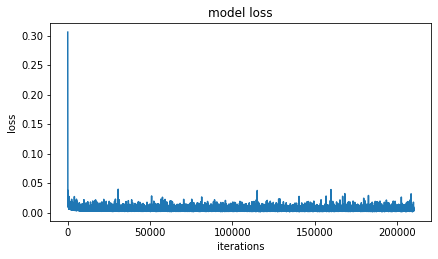

In [0]:
def plot_loss_resnet(losses):
    plt.figure(1, figsize=(15, 8))

    # plotting loss graph
    plt.subplot(221)
    plt.plot(losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    
    # save plot
    plt.savefig('loss_plot_resnet.jpg')

    # show graph
    plt.show()

num_epochs = 14
print('Losses of {} epochs saved'.format(num_epochs))
loss_file_resnet = np.load('drive/My Drive/celeb_detection/losses_{}.npy'.format(num_epochs))
plot_loss_resnet(loss_file)

In [0]:
def plot_loss_gan(gen_losses, disc_losses):
    plt.figure(1, figsize=(15, 8))

    # plotting generator loss graph
    plt.subplot(221)
    plt.plot(gen_losses)
    plt.title('generator loss')
    plt.ylabel('loss')
    plt.xlabel('iterations')

    # plotting discriminator loss graph
    plt.subplot(222)
    plt.plot(disc_losses)
    plt.title('discriminator loss')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    
    # save plot
    plt.savefig('loss_plot_gan.jpg')

    # show graph
    plt.show()

num_epochs = 14
print('Losses of {} epochs saved'.format(num_epochs))
loss_file_gen = np.load('drive/My Drive/celeb_detection/gen_losses_{}.npy'.format(num_epochs))
loss_file_disc = np.load('drive/My Drive/celeb_detection/disc_losses_{}.npy'.format(num_epochs))
plot_loss_gan(loss_file_gen, loss_file_disc)

# Testing

## Preparing data for testing

In [0]:
def copy_data(data_path_drive, data_path, name):
    if os.path.exists(os.path.join(data_path, name)):
        print('Data already present. Not copying!')
    else:
        print('Copying data from drive....')
        start = time()
        src = os.path.join(data_path_drive, name)
        dst = os.path.join(data_path, name)
        shutil.copyfile(src, dst)
        end = time()
        print('Copied | Time Elapsed --> {} seconds'.format(end - start))

data_path = 'data'
data_path_drive = 'drive/My Drive/celeb_detection/data'

model_path = 'model'
model_path_drive = 'drive/My Drive/celeb_detection/model'

frame_path = 'frames'

if not os.path.exists(data_path):
        os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(frame_path):
    os.makedirs(frame_path)

test_file = 'test.jpg'
image_name = 'cdpr1.jpg'
video_name = 'bvs.mp4'
model_name_resnet = 'srresnet_14.pt'
model_name_gan = 'checkpoint_srgan.pth.tar'
model_file = 'models.py'
# copy_data(data_path_drive, '.', model_file)
copy_data(data_path_drive, data_path, test_file)
copy_data(data_path_drive, data_path, image_name)
copy_data(data_path_drive, data_path, video_name)
copy_data(model_path_drive, model_path, model_name_resnet)
# copy_data(model_path_drive, model_path, model_name_gan)

Copying data from drive....
Copied | Time Elapsed --> 2.1327173709869385 seconds
Copying data from drive....
Copied | Time Elapsed --> 0.7230062484741211 seconds
Copying data from drive....
Copied | Time Elapsed --> 1.3910326957702637 seconds
Copying data from drive....
Copied | Time Elapsed --> 3.53895902633667 seconds


## Load resnet and generator models

In [0]:
def load_checkpoint(path, device):
    ckpt = torch.load(path)
    model = ckpt['model']
    model.load_state_dict(ckpt['state_dict'])
    model.to(device)
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [0]:
device = 'cuda'
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
model_resnet = load_checkpoint('model/srresnet_14.pt', device)
model_gan = load_checkpoint('model/gen_14.pt', device)

## Performing super resolution with ResNet and GAN

In [0]:
def test_resnet():
    print('Testing on {}'.format(torch.cuda.get_device_name(0)))
    img = Image.open('data/cdpr1.jpg', mode='r')
    img = img.convert('RGB')
    if (img.width >= 1920 and img.width < 3840) or (img.height >= 1080 and img.height < 2160):
        img = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)
    elif img.width >= 3840 or img.height >= 2160:
        img = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    output = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    resized_output = output.resize((img.width, img.height), Image.BICUBIC)
    transform = ToTensor()
    lr_img = transform(output)
    if lr_img.ndimension() == 3:
        lr_img = (lr_img - imagenet_mean) / imagenet_std
    elif lr_img.ndimension() == 4:
        lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda
    sr_resnet_output = model_resnet(lr_img.unsqueeze(0).to(device))
    
    transform_1 = ToPILImage()

    sr_resnet_output = sr_resnet_output.squeeze(0).cpu().detach()
    sr_resnet_output = (sr_resnet_output + 1.) / 2.
    sr_resnet_output = transform_1(sr_resnet_output)

    grid_image = Image.new('RGB', (2 * img.width, img.height))
    x_offset = 0
    grid_image.paste(resized_output, (x_offset, 0))
    x_offset += img.width
    grid_image.paste(sr_resnet_output, (x_offset, 0))
    grid_image.save('output_resnet.jpg')
    return grid_image

In [0]:
def test_gan():
    print('Testing on {}'.format(torch.cuda.get_device_name(0)))
    img = Image.open('data/cdpr1.jpg', mode='r')
    img = img.convert('RGB')
    if (img.width >= 1920 and img.width < 3840) or (img.height >= 1080 and img.height < 2160):
        img = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)
    elif img.width >= 3840 or img.height >= 2160:
        img = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    output = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    resized_output = output.resize((img.width, img.height), Image.BICUBIC)
    transform = ToTensor()
    lr_img = transform(output)
    if lr_img.ndimension() == 3:
        lr_img = (lr_img - imagenet_mean) / imagenet_std
    elif lr_img.ndimension() == 4:
        lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda
    sr_gan_output = model_gan(lr_img.unsqueeze(0).to(device))
    
    transform_1 = ToPILImage()

    sr_gan_output = sr_gan_output.squeeze(0).cpu().detach()
    sr_gan_output = (sr_gan_output + 1.) / 2.
    sr_gan_output = transform_1(sr_gan_output)

    grid_image = Image.new('RGB', (2 * img.width, img.height))
    x_offset = 0
    grid_image.paste(resized_output, (x_offset, 0))
    x_offset += img.width
    grid_image.paste(sr_gan_output, (x_offset, 0))
    grid_image.save('output_gan.jpg')
    return grid_image

Testing on Tesla T4


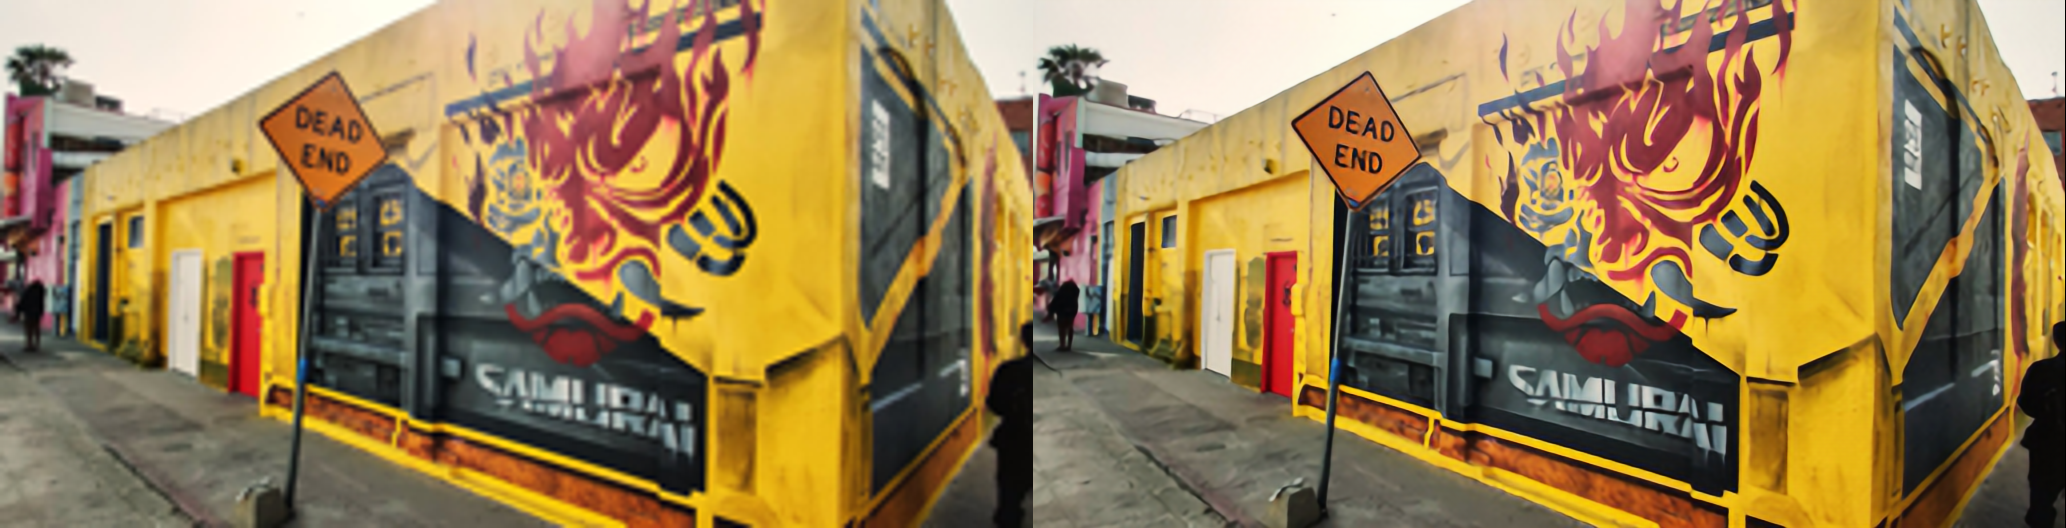

In [0]:
grid_image_resnet = test_resnet()
grid_image_resnet

In [0]:
grid_image_gan = test_gan()
grid_image_gan